In [1]:
import os
import pylas
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from process_tree import process_tree
from process_tree import create_if_not
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

### Generating Views

In [2]:
%%time
fig_list = []

# Read the LAZ file
laz_file_path = 'example_data/LiDAR_example.las'
las = pylas.read(laz_file_path)

gjson = f'example_data/bboxes_example.geojson'
gdf = gpd.read_file(gjson)

# Extract the bounding box of all trees
las_X = las.header.x_offset + las.points['X'] * las.header.x_scale
las_Y = las.header.y_offset + las.points['Y'] * las.header.y_scale
las_Z = las.header.z_offset + las.points['Z'] * las.header.z_scale

# Apply a buffer zone to ensure the integrity of the tree crown
veg_index = np.where(las.classification == 1)
ground_index = np.where(las.classification == 2)

# Create arrays to store coordinates of vegetation and ground points
veg_xyz_all = np.zeros(len(veg_index[0]), dtype=[('X', float), ('Y', float), ('Z', float)])
ground_xyz_all = np.zeros(len(ground_index[0]), dtype=[('X', float), ('Y', float), ('Z', float)])

veg_xyz_all['X'] = las_X[veg_index]
veg_xyz_all['Y'] = las_Y[veg_index]
veg_xyz_all['Z'] = las_Z[veg_index]
ground_xyz_all['X'] = las_X[ground_index]
ground_xyz_all['Y'] = las_Y[ground_index]
ground_xyz_all['Z'] = las_Z[ground_index]


# Construct KD-Trees for efficient nearest-neighbor queries
veg_tree = cKDTree(np.column_stack((veg_xyz_all['X'], veg_xyz_all['Y'])))
ground_tree = cKDTree(np.column_stack((ground_xyz_all['X'], ground_xyz_all['Y'])))

fig_list = []

for index, tree in tqdm(gdf.iterrows(), total=len(gdf), desc='Processing Trees'):
    fig_list.extend(process_tree(tree, veg_tree, ground_tree, veg_xyz_all, 
                                 ground_xyz_all, rotation_angle = 30))

Processing Trees: 100%|██████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.35it/s]

CPU times: total: 15.3 s
Wall time: 15.2 s


### Saving Views

In [3]:
outpath = os.path.join(os.path.expanduser("~"), 'Desktop/Figs')
create_if_not(outpath)

In [4]:
for center, fig, a in tqdm(fig_list, total=len(fig_list), desc='Saving views'):
    fig.savefig(f'{outpath}/x{round(center[0],3)}_y{round(center[1],3)}_angle_{a}.png', bbox_inches='tight')

Saving views: 100%|████████████████████████████████████████████████████████████████| 1500/1500 [00:37<00:00, 39.78it/s]


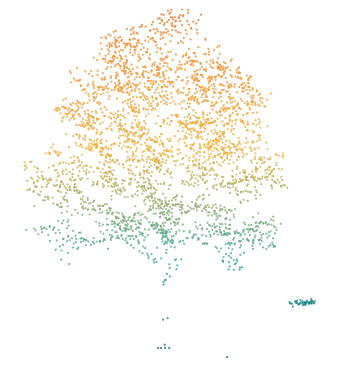

In [7]:
fig_list[10][1]